# Neo4j con Python

http://nicolewhite.github.io/neo4j-jupyter/hello-world.html

In [7]:
from py2neo import Graph

graph = Graph()

In [8]:
graph.delete_all()

In [9]:
from py2neo import Node

nicole = Node("Person", name="Nicole", age=24)
drew = Node("Person", name="Drew", age=20)

mtdew = Node("Drink", name="Mountain Dew", calories=9000)
cokezero = Node("Drink", name="Coke Zero", calories=0)

coke = Node("Manufacturer", name="Coca Cola")
pepsi = Node("Manufacturer", name="Pepsi")

graph.create(nicole | drew | mtdew | cokezero | coke | pepsi)

In [10]:
from scripts.vis import draw

options = {"Person": "name", "Drink": "name", "Manufacturer": "name"}
draw(graph, options)

In [11]:
from py2neo import Relationship

graph.create(Relationship(nicole, "LIKES", cokezero))
graph.create(Relationship(nicole, "LIKES", mtdew))
graph.create(Relationship(drew, "LIKES", mtdew))
graph.create(Relationship(coke, "MAKES", cokezero))
graph.create(Relationship(pepsi, "MAKES", mtdew))

draw(graph, options)

In [12]:
query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS name, drink.name AS drink
"""

data = graph.run(query)

for d in data:
    print(d)

(u'name': u'Nicole', u'drink': u'Mountain Dew')
(u'name': u'Nicole', u'drink': u'Coke Zero')
(u'name': u'Drew', u'drink': u'Mountain Dew')


In [13]:
query = """
MATCH (p:Person)-[:LIKES]->(drink:Drink)
WHERE p.name = {name}
RETURN p.name AS name, AVG(drink.calories) AS avg_calories
"""

data = graph.run(query, name="Nicole")

for d in data:
    print(d)

(u'name': u'Nicole', u'avg_calories': 4500.0)


In [14]:
%load_ext cypher

In [15]:
%%cypher
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name, drink.name, drink.calories

3 rows affected.


person.name,drink.name,drink.calories
Nicole,Mountain Dew,9000
Nicole,Coke Zero,0
Drew,Mountain Dew,9000


In [16]:
results = %cypher MATCH (person:Person)-[:LIKES]->(drink:Drink) \
                  RETURN person.name AS name, drink.name AS drink
    
df = results.get_dataframe()

df

3 rows affected.


,name,drink
0,Nicole,Mountain Dew
1,Nicole,Coke Zero
2,Drew,Mountain Dew


3 rows affected.


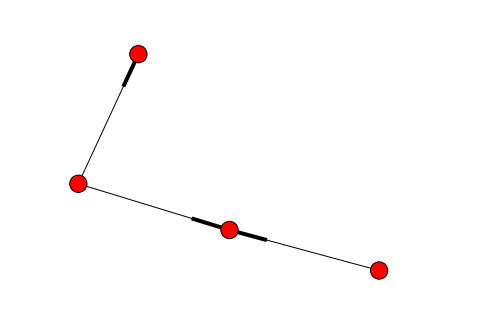

In [17]:
import networkx as nx
%matplotlib inline

results = %cypher MATCH p = (:Person)-[:LIKES]->(:Drink) RETURN p

g = results.get_graph()

nx.draw(g)

In [14]:
g.nodes(data=True)

[(u'52', {u'age': 24, 'labels': [u'Person'], u'name': u'Nicole'}),
 (u'51', {u'calories': 9000, 'labels': [u'Drink'], u'name': u'Mountain Dew'}),
 (u'48', {u'age': 20, 'labels': [u'Person'], u'name': u'Drew'}),
 (u'49', {u'calories': 0, 'labels': [u'Drink'], u'name': u'Coke Zero'})]

In [15]:
nx.degree(g)

{u'48': 1, u'49': 1, u'51': 2, u'52': 2}

In [16]:
from py2neo import Graph as PGraph
from igraph import Graph as IGraph

neo4j = PGraph()

query = """
MATCH (person:Person)-[:LIKES]->(drink:Drink)
RETURN person.name AS source, drink.name AS target
"""

data = neo4j.run(query)
tups = []

for d in data:
    tups.append((d["source"], d["target"]))

In [17]:
ig = IGraph.TupleList(tups)

ig

In [18]:
best = ig.vs.select(_degree = ig.maxdegree())["name"]
best

[u'Mountain Dew', u'Nicole']

In [19]:
import jgraph

jgraph.draw([(1, 2), (2, 3), (3, 4), (4, 1), (4, 5), (5, 2)])

In [20]:
data = graph.run("MATCH (n)-->(m) RETURN ID(n), ID(m)")
data = [tuple(x) for x in data]

jgraph.draw(data)